Liliana Djaja Witama\
2702219774

# UAS Machine Learning
## No 3
Video: https://drive.google.com/file/d/1hBNlTzS4ZtpFOV3CoNJT66jP_PhNgVWa/view?usp=sharing

## variables
Index: row index of the game in the table\
Name: the name of the game\
Platform: the platform for which the game was made\
Year_of_Release: the year in which the game was released\
Genre: the genre of the game\
Publisher: the game’s publisher\
NA_Sales: number of copies sold in North America (millions)\
EU_Sales: number of copies sold in Europe (millions)\
JP_Sales: number of copies sold in Japan (millions)\
Other_Sales: number of copies sold in other countries (millions)\
Global_Sales: the total number of copies sold globally (millions)\
Critic_Score: the average score given by game critics (0-100)\
Critic_Count: the number of game critics that reviewed the game\
User_Score: the average score given by users (0-10)\
User_Count: the number of users playing the game\
Developer: the game’s developer\
Rating: the ESBR categorization of the game (such as E=Everyone, T=Teen, M=Mature, etc.)

## Importing Libraries and Dataset

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import tqdm as tqdm
from matplotlib import pyplot as plt
from scipy.stats import shapiro
from sklearn.preprocessing import RobustScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [31]:
df = pd.read_csv('3A.tsv', sep='\t')
df.head()

,index,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,-706.0,NaN,NaN
2,2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,-92.0,NaN,NaN


## EDA

### Dataframe information

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16928 entries, 0 to 16927
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            16928 non-null  int64  
 1   Name             16926 non-null  object 
 2   Platform         16928 non-null  object 
 3   Year_of_Release  16928 non-null  int64  
 4   Genre            16926 non-null  object 
 5   Publisher        16873 non-null  object 
 6   NA_Sales         16928 non-null  float64
 7   EU_Sales         16928 non-null  float64
 8   JP_Sales         16928 non-null  float64
 9   Other_Sales      16928 non-null  float64
 10  Global_Sales     16928 non-null  float64
 11  Critic_Score     8260 non-null   float64
 12  Critic_Count     8260 non-null   float64
 13  User_Score       10159 non-null  object 
 14  User_Count       16928 non-null  float64
 15  Developer        10240 non-null  object 
 16  Rating           10092 non-null  object 
dtypes: float64(8

There are 16928 rows and 17 columns

### Removing unnecessary variables

In [33]:
df = df.drop(['index'], axis=1)

### Look for null and duplicated values

In [34]:
df.duplicated().sum()

125

In [35]:
df = df.drop_duplicates()

In [36]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release       0
Genre                 2
Publisher            55
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8657
Critic_Count       8657
User_Score         6769
User_Count            0
Developer          6688
Rating             6835
dtype: int64

#### Look at the pattern of the null values

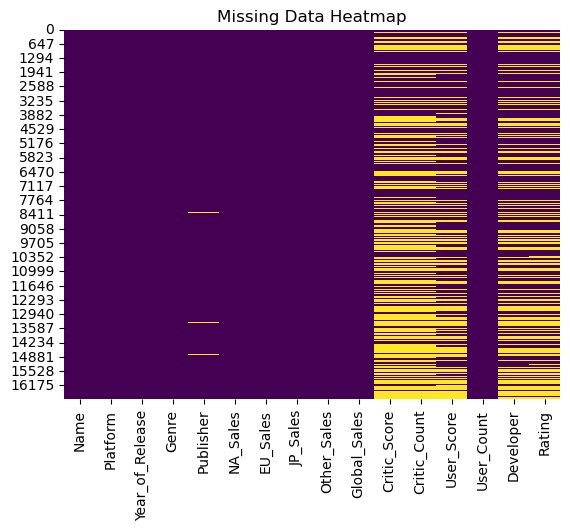

In [37]:
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()

null values for variables ['Critic_Score', 'Critic_Count', 'User_Score', 'Developer'] is almost 50%

### separating numerical and categorical columns

In [38]:
num_cols = []
cat_cols = []

for i in df.columns:
    if 'int' in str(df[i].dtype) or 'float' in str(df[i].dtype):
        num_cols.append(i)
    else:
        cat_cols.append(i)

print('numerical: ', num_cols)
print('categorical: ', cat_cols)

numerical:  ['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Count']
categorical:  ['Name', 'Platform', 'Genre', 'Publisher', 'User_Score', 'Developer', 'Rating']


Here, i will treat variable Year_of_Release as a categorical variable

In [39]:
num_cols.remove('Year_of_Release')
cat_cols.append('Year_of_Release')

### Numerical variables description

In [40]:
df[num_cols].describe()

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,16803.000000,16803.000000,16803.000000,16803.000000,16803.000000,8146.000000,8146.000000,16803.000000
mean,0.263809,0.145097,0.078046,0.047323,0.534529,68.976553,26.354407,-198.951378
std,0.812763,0.502644,0.309075,0.186369,1.546549,13.935846,18.978990,543.298418
min,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,-1000.000000
25%,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,-541.000000
50%,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,-89.000000
75%,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,20.000000
max,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,10665.000000


In [41]:
(df['User_Count'] < 0).sum()

9210

there is an anomaly in variable User_Count where more than 50% of it's value is negative when it logically shouldn't be. hence, i will drop the whole column.

In [42]:
df = df.drop(['User_Count'], axis=1)
num_cols.remove('User_Count')

### unique values in categorical variables

In [43]:
for i in cat_cols:
    print(df[i].value_counts(), '\n')

Name
Need for Speed: Most Wanted                           12
FIFA 14                                                9
Ratatouille                                            9
LEGO Marvel Super Heroes                               9
Madden NFL 07                                          9
                                                      ..
TrackMania: Build to Race                              1
Mega Man Battle Network 5: Team Colonel / Protoman     1
Saka-Tsuku DS: Touch and Direct                        1
Tales of VS.                                           1
Haitaka no Psychedelica                                1
Name: count, Length: 11562, dtype: int64 

Platform
PS2     2169
DS      2160
PS3     1335
Wii     1326
X360    1263
PSP     1211
PS      1210
PC       976
GBA      829
XB       825
GC       560
3DS      525
PSV      435
PS4      396
N64      325
XOne     249
SNES     242
SAT      175
WiiU     147
2600     136
GB        99
NES       98
DC        52
GEN       29
NG  

another anomaly is found in variable User_Score. when we look at the values of User_Score, the variable should be a numerical variable. however, because there is 'tbd' is becomes categorical. thankfully, this will not be a problem because i will drop the column in the null handling step.

### Handling inconsistent data
variable Year_of_Release has a couple weird values like 1, 2, 3, etc. because they're only a small amount, i will just drop those entries.

In [44]:
df = df[~df['Year_of_Release'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])]

### looking at outliers and distribution

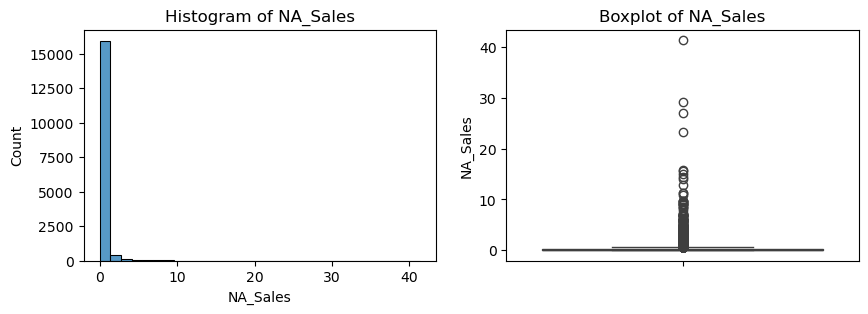

skewness: 18.699287113349147
kurtosis: 642.8628865758454


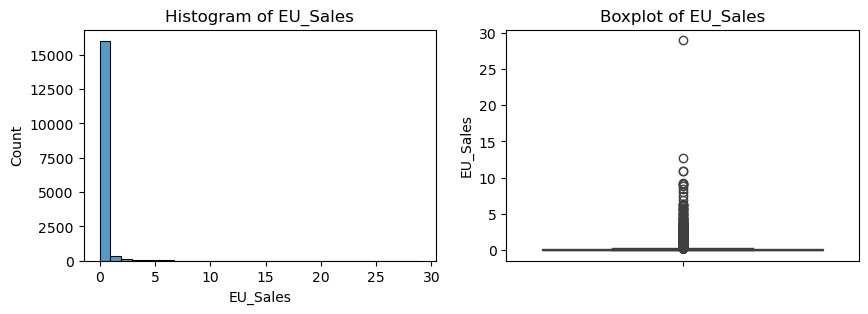

skewness: 18.75570608406053
kurtosis: 747.6675269041326


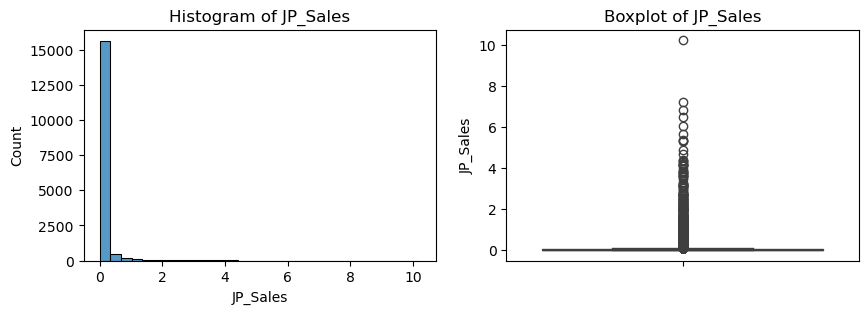

skewness: 11.081350369394599
kurtosis: 190.25339336507162


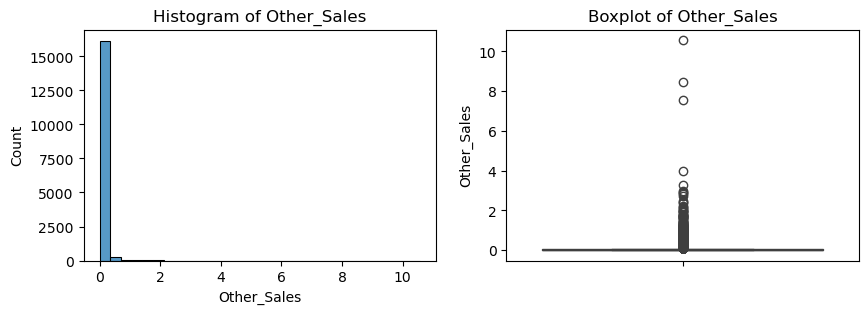

skewness: 24.492156156991477
kurtosis: 1045.9553959323182


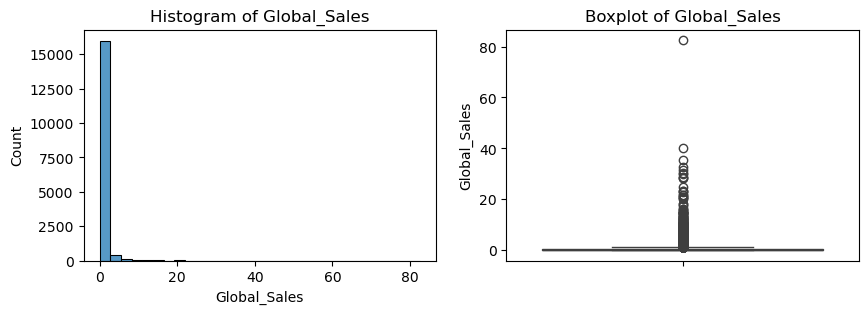

skewness: 17.26854421252801
kurtosis: 596.4868788599185


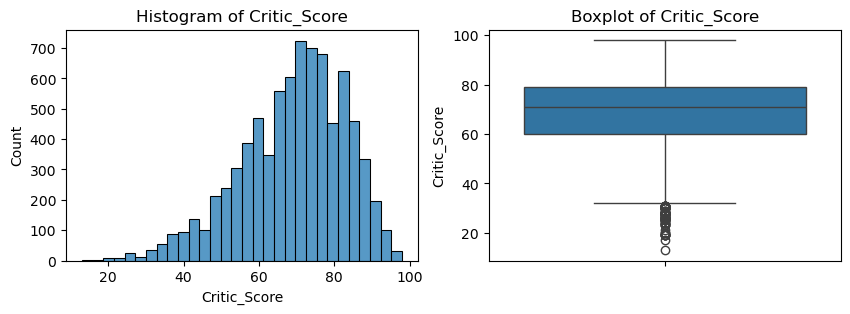

skewness: -0.6132038667538621
kurtosis: 0.14529233496055927


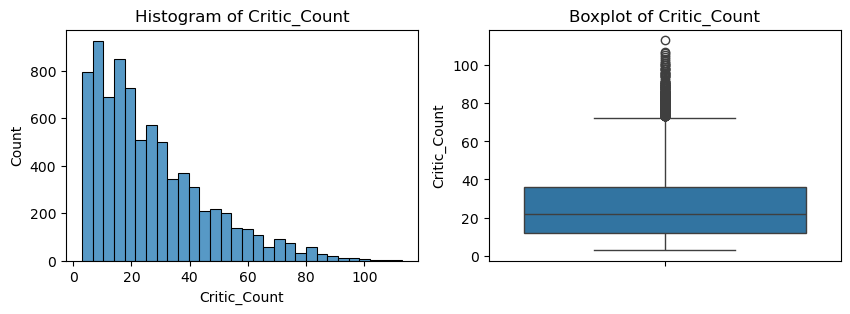

skewness: 1.1521384930501708
kurtosis: 1.0234015530522589


In [45]:
def look_outliers_distribution(df, numerical):
    for col in numerical:
        plt.figure(figsize=(10,3))

        plt.subplot(1,2,1) #,1 = left
        sns.histplot(df[col], bins=30)
        plt.title(f'Histogram of {col}')

        plt.subplot(1,2,2) #,2 = right side
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')

        plt.show()

        print(f'skewness: {df[col].skew()}')
        print(f'kurtosis: {df[col].kurt()}')


look_outliers_distribution(df[num_cols], num_cols)

numerical variables are skewed and have a lot of outliers

### looking at the distribution using shapiro wilk test

In [46]:
for i in num_cols:
    print(i, shapiro(df[i]))

NA_Sales ShapiroResult(statistic=0.26763661051668697, pvalue=2.3447744091276087e-121)
EU_Sales ShapiroResult(statistic=0.2551052264028484, pvalue=7.968581579368491e-122)
JP_Sales ShapiroResult(statistic=0.24691924054179326, pvalue=3.9714395502667293e-122)
Other_Sales ShapiroResult(statistic=0.20236062330583293, pvalue=1.0046718336608544e-123)
Global_Sales ShapiroResult(statistic=0.27321147392249523, pvalue=3.8098279175758036e-121)
Critic_Score ShapiroResult(statistic=nan, pvalue=nan)
Critic_Count ShapiroResult(statistic=nan, pvalue=nan)


c:\Users\lenovo\Documents\anaconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16530.
  res = hypotest_fun_out(*samples, **kwds)


the p-value of all variables are way less than 0.05, so they are not normally distributed

## Null values handling

#### Drop entries that has null values for variable Name and Genre

In [47]:
df = df.dropna(subset=['Name', 'Genre'])

#### Drop column for variables with more than 40% of null values

In [48]:
df = df.drop(['Critic_Score', 'Critic_Count', 'User_Score'], axis=1)

In [49]:
num_cols.remove('Critic_Score')
num_cols.remove('Critic_Count')
cat_cols.remove('User_Score')

#### Imputation for variables Publisher, Developer, and Rating with 'Unknown'

In [50]:
df['Publisher'].fillna('Unknown', inplace=True)
df['Developer'].fillna('Unknown', inplace=True)
df['Rating'].fillna('Unknown', inplace=True)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_12568\756081771.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Publisher'].fillna('Unknown', inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_12568\756081771.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

## Conclusion 
Originally, there were 16928 rows and 17 columns in this dataset. There was 125 duplicated data which I then dropped. Then, I dropped the 'index' column because it's the id variable. There were around 50% of null values found in variables 'Critic_Score', 'Critic_Count', 'User_Score', so I dropped those columns. Null values found in variables Publisher, Developer, and Rating were replaced with 'Unknown' as to retain the information. For null variables found in other variables, I just dropped the rows because the amount was insignificant. Anomalies were found in variable User_Count and Year_of_Release, which then I dropped variable User_Count and dropped the rows containing nulls for Year_of_Release. After EDA and data cleaning, the dataset now has 16528 rows and 13 columns. There are now 5 numerical variables ('NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales') and 7 categorical variables ('Name', 'Platform', 'Genre', 'Publisher', 'Developer', 'Rating', 'Year_of_Release'). There are outliers found in the numerical variables which I kept so that I can keep the important data. They are also skewed and not normally distributed.

## Recommender Model
For the model, I will be using the variables Genre, Platform, Publisher, Developer, Rating, and Global_Sales. I will be combining the TF-IDF method and cosine similarity method.

In [51]:
df['string'] = (
    df['Genre'] + " " +
    df['Platform'] + " " +
    df['Publisher'] + " " +
    df['Developer'] + " " +
    df['Rating']
)

In [52]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['string'])

In [53]:
scaler = RobustScaler()
normalised_numeric = scaler.fit_transform(df[['Global_Sales']].fillna(0))

In [54]:
combined_features = np.hstack([tfidf_matrix.toarray(), normalised_numeric])
cosine_sim = cosine_similarity(combined_features)

In [55]:
def recommend_games(game, cosine_sim=cosine_sim):
    if game not in df['Name'].values:
        return "Game not found!"
    
    idx = df[df['Name'] == game].index[0] #get index
    input_game_info = df.iloc[idx][['Name', 'Platform', 'Genre', 'Publisher']]
    
    #similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    #top 5 recs
    sim_scores = sim_scores[1:6]
    game_indices = [i[0] for i in sim_scores]
    similarity_values = [i[1] for i in sim_scores] 

    recs = df.iloc[game_indices][['Name', 'Platform', 'Genre', 'Publisher']].copy()
    recs['Similarity_Score'] = similarity_values
    recs = pd.concat([pd.DataFrame([input_game_info]), recs], ignore_index=True)

    return recs

In [56]:
games_search = ['Wii Sports', 'Cooking Mama', 'Call of Duty: Black Ops']
for i in games_search:
    print(f'Recommendations for {i}')
    print(recommend_games(i))
    print('\n')

Recommendations for Wii Sports
                        Name Platform     Genre Publisher  Similarity_Score
0                 Wii Sports      Wii    Sports  Nintendo               NaN
1             Mario Kart Wii      Wii    Racing  Nintendo          0.999970
2          Wii Sports Resort      Wii    Sports  Nintendo          0.999970
3          Super Mario Bros.      NES  Platform  Nintendo          0.999953
4                   Wii Play      Wii      Misc  Nintendo          0.999947
5  New Super Mario Bros. Wii      Wii  Platform  Nintendo          0.999942


Recommendations for Cooking Mama
                          Name Platform       Genre  Publisher  \
0                 Cooking Mama       DS  Simulation  505 Games   
1                   Nintendogs       DS  Simulation   Nintendo   
2        New Super Mario Bros.       DS    Platform   Nintendo   
3                   Wii Sports      Wii      Sports   Nintendo   
4  Animal Crossing: Wild World       DS  Simulation   Nintendo   
5     

### Analysis
The recommendations are put into tables. The first index (0) is the game being searched, while index 1-5 are the recommendations. The three inputs I used are 'Wii Sports', 'Cooking Mama', and 'Call of Duty: Black Ops'.

**Wii Sports**\
We can see the similarity between the searched game and the recommendations are focused on Platform, Genre, and Publisher. The Platform of 4 out of 5 of the recommended games are 'Wii' which matches the game being searched, while the other 1 being 'NES'. There is a variety in Genre recommended which are 'Sports', 'Misc', 'Platform', and 'Racing'. All games are published by 'Nintendo'. The similarity scores could also be categorised as good because the best score is of 0.999970 and the worst is of 0.999942, meaning the match is almost perfect.

**Cooking Mama**\
We can see the similarity between the searched game and the recommendations are focused on Platform, Genre, and Publisher. The Platform of most of the recommended games are 'DS' which matches the game being searched, and only one being 'Wii'. Two of the genres also matched, which is 'Simulation'. All the recommended games are published by 'Nintendo'. The similarity scores could also be categorised as good because the best score is of 0.997276 and the worst is of 0.997003.

**Call of Duty: Black Ops**\
We can see the similarity between the searched game and the recommendations are focused on Platform, Genre, and Publisher. The Platform of most of the recommended games are 'X360' which matches the game being searched, and the other two being 'PS3' and 'Wii'. 4 out of 5 of the recommendeed genres are 'Shooter' which matches the game being searched, while the other being 'Sports'. 4 out of 5 of the recommended games are published by 'Activision', while the other 1 is by 'Nintendo'. The similarity scores could also be categorised as good because the best score is of 0.999998 and the worst is of 0.999564, meaning the match is almost perfect.

## Conclusion
This game recommendation system performance is optimal because the recommendations are well associated with the inputs.